# Imports

## Basic Stuff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import shap
import pickle
import os
import math

## sklearn

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, make_scorer, confusion_matrix, roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.inspection import permutation_importance
from scipy.stats import skew, kurtosis

## Models

In [3]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.svm import SVC

# Load CSVs

In [4]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration

## Category Encoder and Decoder

In [5]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [6]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

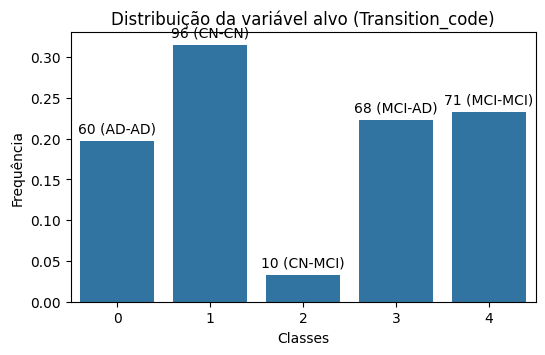

In [7]:
# Obtenção da distribuição e contagem de cada classe
target_distribution = train_df['Transition_code'].value_counts(normalize=True).sort_index()
target_counts = train_df['Transition_code'].value_counts().sort_index()

plt.figure(figsize=(6, 3.5))
ax = sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title("Distribuição da variável alvo (Transition_code)")
plt.xlabel("Classes")
plt.ylabel("Frequência")

le_make = target_encoder(train_df) 
decoded_labels = le_make.inverse_transform(target_distribution.index)

for index, value in enumerate(target_distribution.index):
    ax.text(index, target_distribution[value] + 0.01, f'{target_counts[value]} ({decoded_labels[index]})', ha='center')

plt.show()

## MatPlots

In [8]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [9]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [10]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [11]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(6,3.5))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [12]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [13]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code", height=3, aspect=1.5):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue, height=height, aspect=aspect)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [14]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Basic Exploration

In [15]:
def main_exploration(df):
    print(df.shape) 

In [16]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())

In [17]:
train_df.describe()

,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,lbp-3D-k_glszm_ZonePercentage,lbp-3D-k_glszm_ZoneVariance,lbp-3D-k_ngtdm_Busyness,lbp-3D-k_ngtdm_Coarseness,lbp-3D-k_ngtdm_Complexity,lbp-3D-k_ngtdm_Contrast,lbp-3D-k_ngtdm_Strength,Sex,Age,Transition_code
count,305.0,305.000000,305.0,305.000000,305.000000,305.0,305.000000,305.000000,305.000000,305.000000,...,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000,305.000000
mean,3.0,5.810469,0.0,173.504918,6714.790164,2.0,0.411819,0.096916,10.137707,104.883349,...,0.010477,266015.006289,362.064990,0.002024,0.155767,0.012415,0.002091,0.567213,75.171148,1.980328
std,0.0,0.613858,0.0,24.108871,1066.815670,0.0,0.028993,0.009739,0.911329,6.180335,...,0.002009,59267.210682,102.133366,0.000531,0.024285,0.003814,0.000552,0.496276,6.675866,1.504251
min,3.0,4.321602,0.0,128.000000,3609.000000,2.0,0.330890,0.075142,8.420713,90.675836,...,0.005818,138177.996378,130.618182,0.001137,0.071124,0.002565,0.001168,0.000000,55.300000,0.000000
25%,3.0,5.317298,0.0,157.000000,5941.000000,2.0,0.392944,0.089977,9.525253,100.501871,...,0.009060,225781.559367,285.617369,0.001632,0.140791,0.009751,0.001688,0.000000,71.300000,1.000000
50%,3.0,5.811449,0.0,172.000000,6723.000000,2.0,0.412479,0.096609,10.106838,104.370667,...,0.010580,259226.493061,353.841144,0.001934,0.156580,0.012297,0.001995,1.000000,75.000000,1.000000
75%,3.0,6.237751,0.0,190.000000,7396.000000,2.0,0.431621,0.102240,10.635093,108.677326,...,0.011706,298836.166667,431.288497,0.002305,0.173700,0.015166,0.002373,1.000000,79.900000,3.000000
max,3.0,7.583210,0.0,255.000000,9453.000000,2.0,0.491496,0.144082,14.370911,126.209296,...,0.017015,465865.829238,670.406531,0.004325,0.223273,0.024548,0.004417,1.000000,91.000000,4.000000


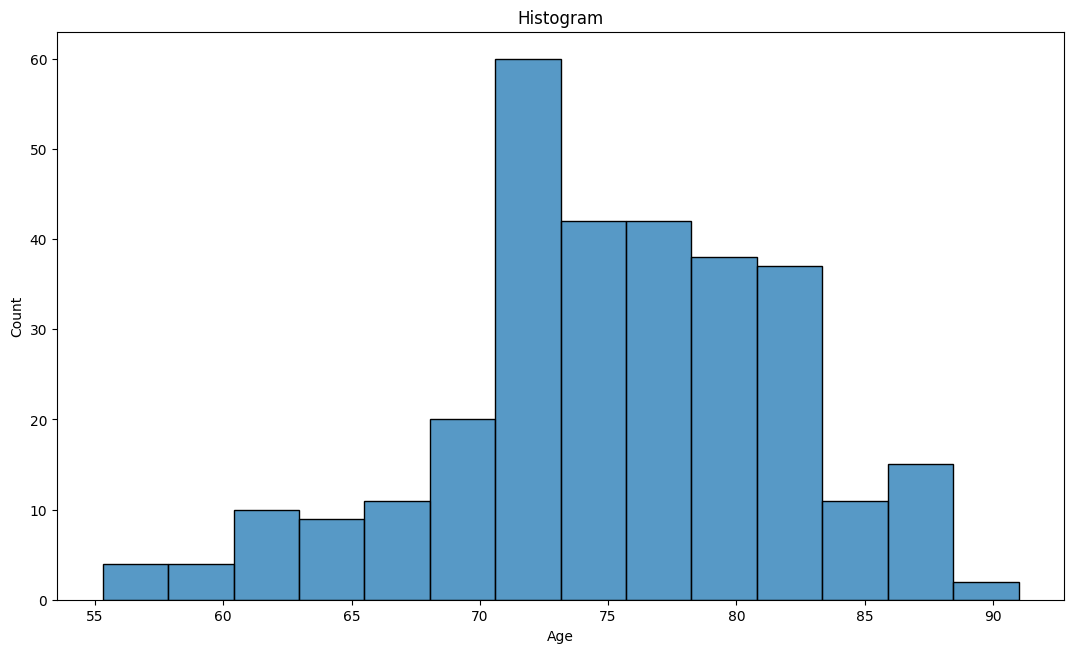

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


In [18]:
numerical_exploration(train_df)

In [19]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())

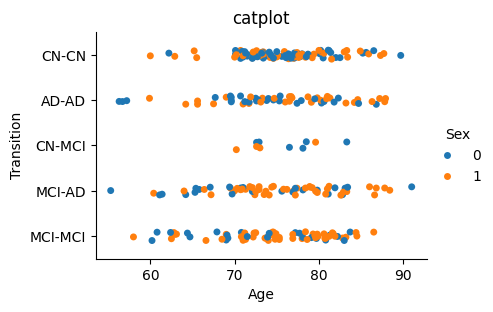

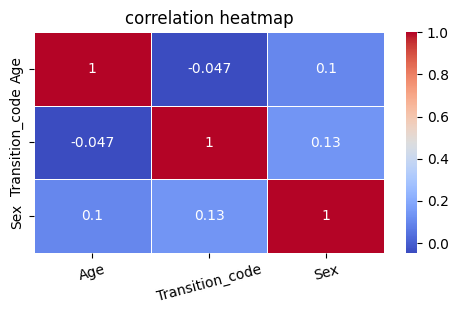

In [20]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

In [21]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [22]:
diagnostics_configs(train_df)

1
1


In [23]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [24]:
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [25]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 

In [26]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]

In [27]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex','diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes']

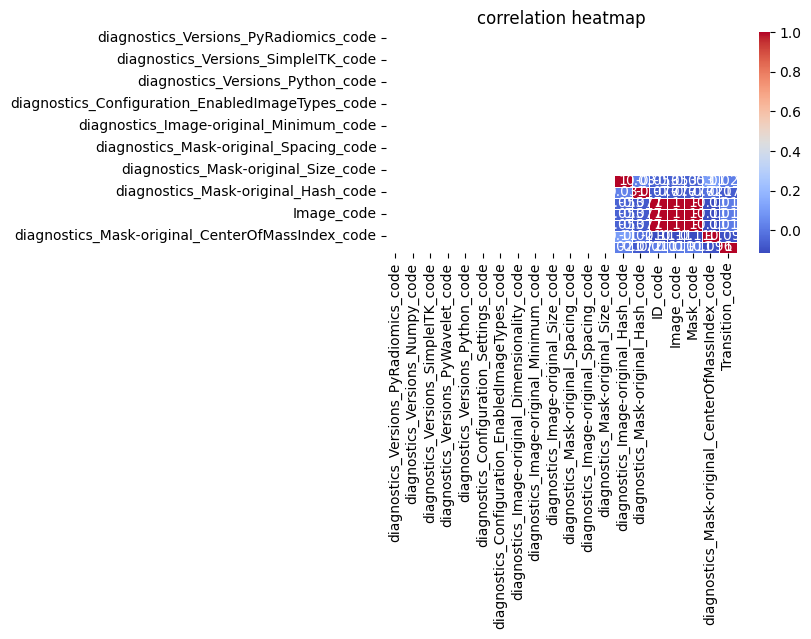

In [28]:
unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

In [29]:
colunas_nao_numericas = train_df.select_dtypes(exclude=['number']).columns

print(train_df[colunas_nao_numericas].head())

           ID                                              Image  \
0  006_S_0681  /notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...   
1  941_S_1203  /notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...   
2  011_S_0003  /notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...   
3  057_S_0779  /notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...   
4  033_S_0920  /notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...   

                                                Mask  \
0  /notebooks/disk2/DS2_FreeSurfer/ADNI_006_S_068...   
1  /notebooks/disk2/DS2_FreeSurfer/ADNI_941_S_120...   
2  /notebooks/disk2/DS2_FreeSurfer/ADNI_011_S_000...   
3  /notebooks/disk2/DS2_FreeSurfer/ADNI_057_S_077...   
4  /notebooks/disk2/DS2_FreeSurfer/ADNI_033_S_092...   

  diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                            2.2.0                     1.18.5   
1                            2.2.0                     1.18.5   
2                            2.2.0                     1.18

## Correlations

In [30]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


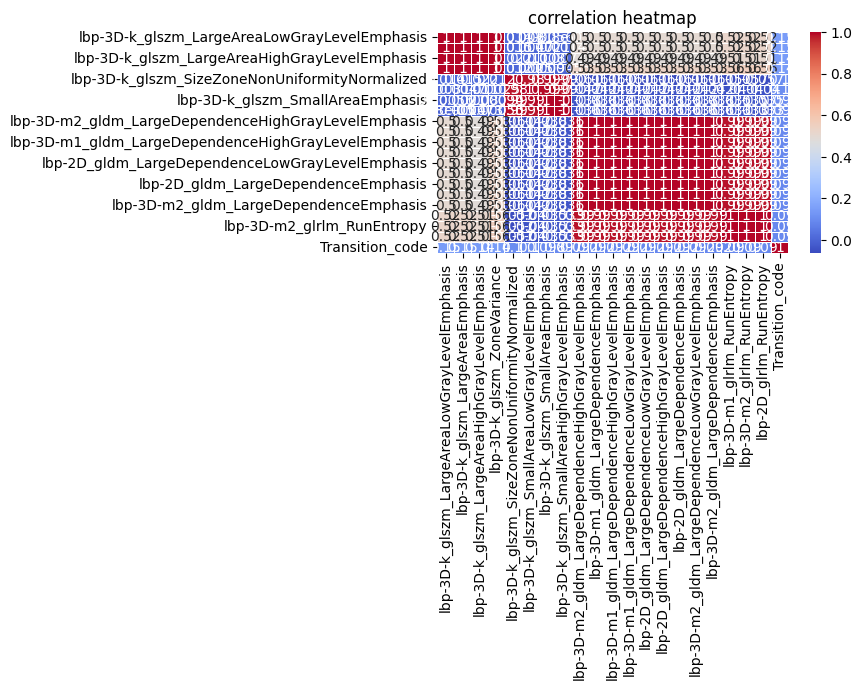

In [31]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

# Save & Load Data

In [32]:
uni_path = "../DataSaver/"

def save_stuff(data,path):
    file_path = os.path.join(uni_path, path)
    
    with open(file_path,"wb") as file:
        pickle.dump(data,file)

def load_stuff(path):
    file_path = os.path.join(uni_path,path)

    with open(file_path,"rb") as file:
        data = pickle.load(file)

    return data

# Data Processing

## Drop Unnecessary Columns

In [33]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

In [34]:
train_df[['diagnostics_Mask-original_BoundingBox']]


,diagnostics_Mask-original_BoundingBox
0,"(103, 113, 93, 36, 30, 71)"
1,"(81, 127, 93, 47, 16, 73)"
2,"(77, 119, 89, 49, 30, 81)"
3,"(93, 102, 90, 41, 29, 78)"
4,"(87, 119, 91, 40, 27, 75)"
...,...
300,"(88, 118, 89, 41, 25, 78)"
301,"(103, 103, 93, 38, 27, 70)"
302,"(80, 131, 89, 48, 17, 82)"
303,"(93, 103, 91, 40, 31, 75)"


## Non Numerical Columns

In [35]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [36]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [37]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)

# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [38]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostaics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

In [39]:
main_exploration(train_df)

(305, 2170)


In [40]:
train_df = train_df.select_dtypes(include=['number'])
control_df = control_df.select_dtypes(include=['number'])
test_df = test_df.select_dtypes(include=['number'])

## Data Scaler

In [41]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [42]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

scaled_train_df["Transition_code"] = train_df["Transition_code"].values
scaled_control_df["Transition_code"] = train_df["Transition_code"].values

scaled_train_df.shape

(305, 2169)

## Correlation Analisys

In [43]:
corr_df = scaled_train_df.copy()
corr_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
target = "Transition_code"

In [44]:
corr_threshold = 0
def apply_correlation(df,threshold):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features

In [45]:
important_features = apply_correlation(scaled_train_df, corr_threshold)

In [46]:
corr_train_df = scaled_train_df
corr_control_df = scaled_control_df
corr_test_df = scaled_test_df
corr_train_df.shape

(305, 2169)

In [47]:
corr_train_df["Transition_code"] = train_df["Transition_code"].values
corr_control_df["Transition_code"] = train_df["Transition_code"].values

In [48]:
main_exploration(corr_train_df)
main_exploration(corr_control_df)
main_exploration(corr_test_df)

(305, 2169)
(305, 2169)
(100, 2168)


# Testing Phase

In [49]:
def define_X_y(train_df, test_df = pd.DataFrame(),random_state=27):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=random_state)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [50]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(corr_train_df,corr_test_df)
main_exploration(x_train)
main_exploration(x_test)

scorer = make_scorer(f1_score, average='macro')

(305, 2168)
(100, 2168)


## Params

In [51]:
total_samples = len(x_train)

class_counts = np.bincount(y_train)

scale_pos_weight = total_samples / class_counts

weights = {i:w for i,w in enumerate(scale_pos_weight)}

sample_class_weights = {i: total_samples / count for i,count in enumerate(class_counts)}
sample_weights = np.array([sample_class_weights[label] for label in y_train])

### Grid Params

In [71]:
stacking = load_stuff("Models/New_Models/new_era_stackingsvm.pkl")

In [72]:
stacking

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=27, shuffle=True),
                   estimators=[('svm',
                                SVC(C=7, class_weight='balanced',
                                    random_state=27)),
                               ('rf',
                                RandomForestClassifier(bootstrap=False,
                                                       class_weight='balanced_subsample',
                                                       max_depth=10,
                                                       min_samples_leaf=2,
                                                       random_state=27)),
                               ('xgb',
                                XGBClassifier(alpha=0.1, base_score=None,
                                              booster=None, callbacks=Non...
                                              n_estimators=100, n_jobs=None, ...)),
                               ('light',
                                LGBMClassifier(bagging_fraction=0.7,
                                               class_weight={0: 5.083333333333333,
                                                             1: 3.1770833333333335,
                                                             2: 30.5,
                                                             3: 4.485294117647059,
                                                             4: 4.295774647887324},
                                               max_depth=5, min_data_in_leaf=20,
                                               num_leaves=20,
                                               objective='multiclassova',
                                               random_state=27, verbose=-1))],
                   final_estimator=LogisticRegression(max_iter=3000,
                                                      random_state=27),
                   n_jobs=-1)

In [75]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}


param_grid_xgb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [2, 3, 5],
    'objective': ['multi:softprob'],
    'alpha': [0.01, 0.05, 0.1, 1, 10],
    'lambda': [0.5, 1, 5, 10, 100]
}


param_grid_light = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 30, 40],
    'max_depth': [3, 5, 10, 15],
    'min_data_in_leaf': [10, 20, 30],
    'bagging_fraction': [0.5, 0.7, 0.8, 1.0],
    'objective': ['multiclassova'],
}


param_grid_svm = {
    'C': [0.1, 0.5, 1, 2, 5, 7, 10],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced'],
}


param_grid_gb = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 10, 15],
    'subsample': [0.7, 0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_cat = {
    'learning_rate': [0.05, 0.1, 0.2],
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [32, 50, 100],
    'class_weights': [None, 'balanced']
}


### Bayes Params

In [76]:
param_baye_rf = {
    'n_estimators': (100, 300),
    'max_depth': (5, 30),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 4),
    'bootstrap': (0, 1),
    'class_weight': (0, 1),
}


param_baye_xgb = {
    'learning_rate': (0.05, 0.15),
    'n_estimators': (100, 300),
    'max_depth': (6, 15),
    'subsample': (0.7, 1.0),
    'colsample_bytree': (0.7, 1.0),
    'min_child_weight': (1, 5),
}


param_baye_gb = {
    'learning_rate': (0.05, 0.2),
    'n_estimators': (100, 300),
    'max_depth': (6, 15),
    'subsample': (0.7, 1.0),
    'min_samples_split': (2, 8),
    'min_samples_leaf': (1, 4),
}


param_baye_cat = {
    'learning_rate': (0.05, 0.2),
    'iterations': (100, 300),
    'depth': (6, 10),
    'l2_leaf_reg': (3, 7),
    'border_count': (32, 100)
}


param_baye_light = {
    'learning_rate': (0.05, 0.2),
    'num_leaves': (30, 50),
    'max_depth': (5, 15),
    'min_data_in_leaf': (10, 30),
    'bagging_fraction': (0.7, 1.0)
}


param_baye_svm = {
    'C': (1, 100),
    'gamma': (0.01, 1),
    'kernel': (0, 1),
    'class_weight': (0, 1),
    'degree': (2, 4),
    'tol': (1e-4, 1e-3),
    'cache_size': (200, 300),
}


## Models

### SVM

In [137]:
def svm_train_model(x_train,y_train):
    model = SVC(random_state=27,class_weight="balanced", probability=True)
    model.fit(x_train,y_train)

    return model

# Grid Model
def svm_grid_train_model(x_train,y_train, param_grid=param_grid_svm):
    model = SVC(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid, cv=cv, n_iter=600,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

def objective_svm(C, gamma, kernel, class_weight, degree, tol, cache_size):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'C': C,
        'gamma': 'scale' if round(gamma) == 0 else gamma,  # 'scale' ou um valor float de gamma
        'kernel': 'linear' if round(kernel) == 0 else 'rbf',  # 'linear' ou 'rbf'
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'degree': int(degree) if round(kernel) == 1 else 3,  # Degree apenas para kernel polinomial
        'tol': tol,
        'cache_size': cache_size,  # Cache size em MB
        'random_state': 27
    }
    
    model = SVC(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring='accuracy').mean()  # Troque "scorer" por "accuracy"
    return score

def svm_baye_train_model(x_train, y_train, param_baye=param_baye_svm):
    svm_bo = BayesianOptimization(
        f=objective_svm,
        pbounds=param_baye,
        random_state=27,
    )
    
    svm_bo.maximize(init_points=7, n_iter=45)

    best_params = svm_bo.max['params']

    gamma = 'scale' if round(best_params["gamma"]) == 0 else best_params["gamma"]
    kernel = 'linear' if round(best_params["kernel"]) == 0 else 'rbf'
    best_params_updated = {
        'C': best_params['C'],
        'gamma': gamma,
        'kernel': kernel,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'degree': int(best_params['degree']) if kernel == 'rbf' else 3,  # Degree só para kernel 'rbf'
        'tol': best_params['tol'],
        'cache_size': best_params['cache_size'],
        'random_state': 27
    }

    print(best_params_updated)

    model = SVC(**best_params_updated)
    model.fit(x_train, y_train)

    svm_results = pd.DataFrame(svm_bo.res)
    svm_results.sort_values(by="target", ascending=False, inplace=True)

    return model, svm_results, svm_bo.max

### RandomForest

In [138]:
# Basic Model
def random_forest_model(x_train,y_train):
    model = RandomForestClassifier(random_state=27,class_weight= 'balanced_subsample')
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def random_forest_grid_model(x_train,y_train, param_grid_rf=param_grid_rf):
    model = RandomForestClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)
    
    grid_search = RandomizedSearchCV(model, param_grid_rf, cv=cv, n_iter=1000,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

#Bayes Model
def objective_random_forest(n_estimators, max_depth, min_samples_split, min_samples_leaf,bootstrap,class_weight):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'bootstrap': bool(round(bootstrap)),
        'class_weight': None if round(class_weight) == 0 else 'balanced',
        'random_state': 27
    }
    
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score

def random_forest_baye_model(x_train,y_train, param_baye=param_baye_rf):
    rf_bo = BayesianOptimization(
        f=objective_random_forest,
        pbounds=param_baye,
        random_state=27,
    )
    
    rf_bo.maximize(init_points=7, n_iter=45)

    best_params = rf_bo.max['params']
    bootstrap = bool(round(best_params["bootstrap"]))
    best_params_updated = {
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),
        'min_samples_split': int(best_params['min_samples_split']),
        'min_samples_leaf': int(best_params['min_samples_leaf']),
        'bootstrap': bootstrap,
        'class_weight': None if round(best_params['class_weight']) == 0 else 'balanced',
        'random_state': 27
    }

    print(best_params_updated)

    model = RandomForestClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    rf_results = pd.DataFrame(rf_bo.res)
    rf_results.sort_values(by="target",ascending=False,inplace=True)

    return model, rf_results, rf_bo.max

### XGBoost

In [139]:
# Basic Model
def xgboost_model(x_train,y_train):
    model = XGBClassifier(random_state=27,objective= 'multi:softprob')
    model.fit(x_train,y_train, sample_weight=sample_weights)

    return model

# Grid Model
def xgboost_grid_model(x_train,y_train, param_grid_xgb=param_grid_xgb):
    model = XGBClassifier(random_state=27)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_xgb, cv=cv, n_iter=1000,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)
    

    return grid_search.best_estimator_

# Baye Model
def objective_xgboost(learning_rate, n_estimators, max_depth, subsample, colsample_bytree,min_child_weight):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'min_child_weight': min_child_weight,
        'random_state': 27
    }
    
    model = XGBClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score
    
def xgboost_baye_model(x_train,y_train, param_baye=param_baye_xgb):
    xgb_bo = BayesianOptimization(
    f=objective_xgboost,
    pbounds=param_baye,
    random_state=27,
    )
    
    xgb_bo.maximize(init_points=7, n_iter=30)

    best_params = xgb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']), 
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'min_child_weight': best_params['min_child_weight'],
        'random_state': 27
    }

    print(best_params_updated)
    
    model = XGBClassifier(**best_params_updated)
    model.fit(x_train,y_train, sample_weight=sample_weights)

    xgb_results = pd.DataFrame(xgb_bo.res)
    xgb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, xgb_results, xgb_bo.max

### LightGBM

In [140]:
# Basic Model
def light_boost_model(x_train,y_train):
    model =  lgb.LGBMClassifier(verbose=-1,objective='multiclassova',class_weight=weights)
    model.fit(x_train,y_train)

    return model

# Grid Model
def light_grid_train_model(x_train,y_train, param_grid=param_grid_light):
    model = lgb.LGBMClassifier(verbose=-1,random_state=27,class_weight=weights)
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=27)

    grid_search = RandomizedSearchCV(model, param_grid_light, cv=cv, n_iter=600,random_state=27, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search.fit(x_train,y_train)
    print(grid_search.best_params_)

    return grid_search.best_estimator_

# Bayes Model
def objective_light_boost(learning_rate, num_leaves, max_depth, min_data_in_leaf, bagging_fraction):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'min_data_in_leaf': int(min_data_in_leaf),
        'bagging_fraction': bagging_fraction,
        'boosting_type': 'gbdt',
        'objective': 'multiclass', 
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def light_baye_train_model(x_train, y_train, param_baye=param_baye_light):
    light_bo = BayesianOptimization(
        f=objective_light_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    light_bo.maximize(init_points=7, n_iter=45)

    best_params = light_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'num_leaves': int(best_params['num_leaves']),
        'max_depth': int(best_params['max_depth']),
        'min_data_in_leaf': int(best_params['min_data_in_leaf']),
        'bagging_fraction': best_params['bagging_fraction'],
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'is_unbalance': True,
        'n_jobs': -1,
        'random_state': 27,
        'verbose': -1
    }

    print(best_params_updated)
    
    model = lgb.LGBMClassifier(**best_params_updated)
    model.fit(x_train, y_train)

    light_results = pd.DataFrame(light_bo.res)
    light_results.sort_values(by="target", ascending=False, inplace=True)

    return model, light_results, light_bo.max

### GradientBoost

In [141]:
# Basic Model
def gradient_boost_model(x_train, y_train):
    model = GradientBoostingClassifier(random_state=27)
    model.fit(x_train,y_train)
    
    return model

# Grid Model
def gradient_grid_model(x_train,y_train, param_grid_gb=param_grid_gb):
    model = GradientBoostingClassifier(random_state=27)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)

    grid_search_gb = GridSearchCV(model, param_grid_gb, cv=cv, scoring=scorer, n_jobs=-1, verbose=1)
    grid_search_gb.fit(x_train,y_train)
    print(grid_search_gb.best_params_)

    return grid_search_gb.best_estimator_


# Baye Model
def objective_gradient_boost(learning_rate, n_estimators, max_depth, subsample,min_samples_split,min_samples_leaf):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'subsample': subsample,
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 27
    }
    
    model = GradientBoostingClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def gradient_baye_model(x_train,y_train, param_baye=param_baye_gb):
    gb_bo = BayesianOptimization(
        f=objective_gradient_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    gb_bo.maximize(init_points=7, n_iter=70)

    best_params = gb_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'n_estimators': int(best_params['n_estimators']),
        'max_depth': int(best_params['max_depth']),  
        'subsample': best_params['subsample'],
        'min_samples_split': int(best_params['min_samples_split']), 
        'min_samples_leaf': int(best_params['min_samples_leaf']), 
        'random_state': 27 
    }

    print(best_params_updated)
    
    model = GradientBoostingClassifier(**best_params_updated)
    model.fit(x_train,y_train)

    gb_results = pd.DataFrame(gb_bo.res)
    gb_results.sort_values(by="target",ascending=False,inplace=True)

    return model, gb_results, gb_bo.max

### CatBoosting

In [59]:
# Basic Model
def cat_boost_model(x_train,y_train):
    model = CatBoostClassifier(verbose=False, task_type="GPU")
    model.fit(x_train,y_train)

    return model

# Bayes Model
def objective_cat_boost(learning_rate, iterations, depth, l2_leaf_reg, border_count):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=27)
    
    params = {
        'learning_rate': learning_rate,
        'iterations': int(iterations),
        'depth': int(depth),
        'l2_leaf_reg': l2_leaf_reg,
        'border_count': int(border_count),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }
    
    model = CatBoostClassifier(**params)
    score = cross_val_score(model, x_train, y_train, cv=cv, scoring=scorer).mean()
    return score


def cat_baye_model(x_train, y_train, param_baye=param_baye_cat):
    cat_bo = BayesianOptimization(
        f=objective_cat_boost,
        pbounds=param_baye,
        random_state=27,
    )
    
    cat_bo.maximize(init_points=5, n_iter=20)


    best_params = cat_bo.max['params']
    best_params_updated = {
        'learning_rate': best_params['learning_rate'],
        'iterations': int(best_params['iterations']),
        'depth': int(best_params['depth']),
        'l2_leaf_reg': best_params['l2_leaf_reg'],
        'border_count': int(best_params['border_count']),
        'task_type': 'GPU',
        'random_seed': 27,
        'verbose': 0
    }

    print(best_params_updated)
    

    model = CatBoostClassifier(**best_params_updated)
    model.fit(x_train, y_train)


    cat_results = pd.DataFrame(cat_bo.res)
    cat_results.sort_values(by="target", ascending=False, inplace=True)

    return model, cat_results, cat_bo.max

### Logistic Regression L2

In [81]:
def log_reg_model(x_train,y_train):
    model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=27)
    model.fit(x_train,y_train)
    
    return model

### Voting Ensemble

In [82]:
def voting_ensemble(x_train,y_train,estimators):
    model = VotingClassifier(estimators=estimators, voting="hard")
    model.fit(x_train,y_train)
    
    return model

### Stacking Ensemble

In [83]:
def stacking_ensemble(x_train,y_train,estimators):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
    
    model = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(max_iter=3000, random_state=27), 
        cv=cv, 
        n_jobs=-1,
    )
    
    model.fit(x_train,y_train)
    
    return model

## Models Applier

In [84]:
def apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=5, title="Models Macro F1 Comparison", rf=1, xgb=1, gradient=0, cat=0, log=0, light=1,svm=1):
        
    if rf:
        rf_model = random_forest_model(x_train,y_train)
        results["RandomForest"] = [rf_model,None]
    else:
        rf_model = None

    if xgb:
        xgb_model = xgboost_model(x_train,y_train)
        results["XGBoost"] = [xgb_model,None]
    else:
        xgb_model = None
        
    if gradient:
        gradient_model = gradient_boost_model(x_train,y_train)
        results["GradientBoost"] = [gradient_model,None]
    else:
        gradient_model = None
        
    if cat:
        cat_model = cat_boost_model(x_train,y_train)
        results["CatBoost"] = [cat_model,None]
    else:
        cat_model = None
        
    if log:
        log_model = log_reg_model(x_train,y_train)
        results["Logistic"] = [log_model,None]
    else:
        log_model = None      

    if light:
        light_model = light_boost_model(x_train,y_train)
        results["LightGBM"] = [light_model,None]
    else:
        light_model = None  

    if svm:
        svm_model = svm_train_model(x_train,y_train)
        results["SVM"] = [svm_model,None]
    else:
        svm_model = None 

    models_comparison(results,title,x_train=x_train,y_train=y_train,n_repeats=n_repeats)

    return rf_model, xgb_model, gradient_model, cat_model, log_model, light_model, svm_model

## Models Comparison

In [85]:
def models_comparison(results, title, x_train, y_train,n_repeats=5):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=n_repeats, random_state=27)
    
    for result in results:
        if results[result][1] is None:
            # Calcular F1 Score usando cross-validation
            f1_scores = cross_val_score(
                results[result][0], x_train, y_train, cv=cv, scoring=make_scorer(f1_score, average="macro")
            )
            results[result][1] = f1_scores.mean()
            print(f"F1 Macro Score em {result}: {results[result][1]} ± {round(f1_scores.std(),3)}")
        
        else:
            print(f"F1 Macro Score em {result}: {results[result][1]}")
        
    
    # Criar gráfico
    models_score = plt.figure(figsize=(6, 3))

    mod = list(results.keys())
    f1 = list([score[1] for score in results.values()])
    
    plt.bar(mod, f1, color="lightblue", width=0.5)
    plt.xlabel("Modelo")
    plt.ylabel("Macro F1")
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()

## MultiClass Analysis

In [86]:
def class_accuracy(model,x_test,y_test):
    conf_matrix = confusion_matrix(y_test, model.predict(x_test))
    # grafico de barras com a percentagem de acertos
    class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    class_accuracies_percentage = class_accuracies * 100  
    total_per_class = np.sum(conf_matrix, axis=1) 
    correct_per_class = np.diag(conf_matrix) 
    
    plt.figure(figsize=(7, 4))
    classes = np.unique(y_test)
    plt.bar(classes, class_accuracies_percentage, color='skyblue', alpha=0.8)
    plt.xlabel("Classes")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy per Class")
    plt.ylim(0, 100) 
    

    for i, v in enumerate(class_accuracies_percentage):
        text = f"{correct_per_class[i]}/{total_per_class[i]} ({v:.1f}%)"
        plt.text(classes[i], v + 2, text, ha='center', fontsize=10)
    
    plt.show()
    
    # matriz de confusão
    
    plt.figure(figsize=(7, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predict")
    plt.ylabel("Real Values")
    plt.title("Confusion Matrix")
    plt.show()


## ROC & AUC Analysis

In [87]:
def roc_auc(models, X_train, y_train, X_test, y_test):
    # Binariza o target para multiclasse
    y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4])
    n_classes = y_test_bin.shape[1]

    # Define o número de linhas e colunas para a grade de subgráficos, ajustando para o número de classes
    n_cols = 2  # Define um número fixo de colunas
    n_rows = math.ceil(n_classes / n_cols)  # Calcula o número de linhas necessárias

    # Configura os subgráficos e aumenta o tamanho da figura
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
    axs = axs.flatten()  # Achata a matriz de axs para facilitar o acesso
    
    colors = ['blue', 'green', 'red', 'purple', 'orange']  # Cores para cada modelo

    for classe in range(n_classes):
        ax = axs[classe]  # Acessa o subplot correspondente à classe

        for i, (name, model) in enumerate(models.items()):
            y_score = model.predict_proba(X_test)
            
            # Calcula a curva ROC e AUC para a classe atual e o modelo atual
            fpr, tpr, _ = roc_curve(y_test_bin[:, classe], y_score[:, classe])
            auc = roc_auc_score(y_test_bin[:, classe], y_score[:, classe])
            
            
            # Plota a curva ROC para o modelo na classe atual
            ax.plot(fpr, tpr, color=colors[i], linestyle='--', label=f'{name} {classe} (AUC = {auc:.2f})')
        
        # Linha de referência (modelo aleatório)
        ax.plot([0, 1], [0, 1], 'k--', label='Aleatório (AUC = 0.5)')
        ax.set_title(f'Classe {classe}')
        ax.set_xlabel('Falsos Positivos (FPR)')
        
        # Apenas o primeiro gráfico precisa do rótulo do eixo Y
        if classe % n_cols == 0:
            ax.set_ylabel('Verdadeiros Positivos (TPR)')
        
        # Adiciona a legenda em cada subgráfico
        ax.legend(loc='lower right')

    # Remove subgráficos extras, caso o número de classes não preencha todos os subgráficos
    for i in range(n_classes, len(axs)):
        fig.delaxes(axs[i])
    
    # Título principal
    plt.suptitle('Curvas ROC Multiclasse Comparativas (One-vs-Rest)')
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o layout para incluir o título
    plt.show()

# Models Tester

F1 Macro Score em RandomForest: 0.309237841501754 ± 0.031
F1 Macro Score em XGBoost: 0.34006787359954926 ± 0.047
F1 Macro Score em LightGBM: 0.35277333029523583 ± 0.055
F1 Macro Score em SVM: 0.3010927542574074 ± 0.038


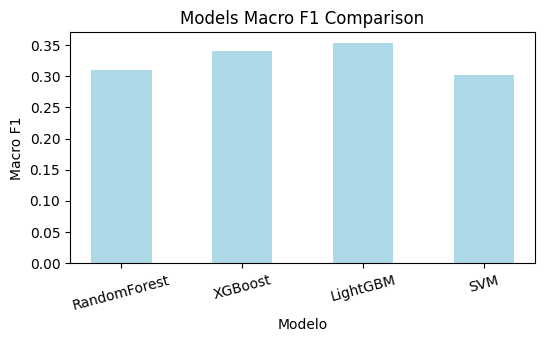

In [73]:
rf_model,xgb_model,gradient_model,cat_model, log_model,light_model, svm_model = apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=3)

F1 Macro Score em RandomForest: 0.309237841501754
F1 Macro Score em XGBoost: 0.34006787359954926
F1 Macro Score em LightGBM: 0.35277333029523583
F1 Macro Score em SVM: 0.3010927542574074
F1 Macro Score em StackingBasicSVM: 0.32419420053000575 ± 0.063


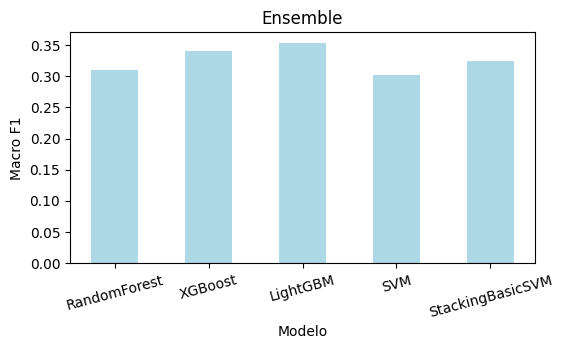

In [74]:
stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_model),("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasicSVM"] = [stacking_model_svm,None]


models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=4)

In [68]:
models = {"RF": rf_model,"XGB": xgb_model,"Light":light_model}
roc_auc(models,x_train,y_train,x_test,y_test)

InvalidParameterError: The 'y' parameter of label_binarize must be an array-like or a sparse matrix. Got None instead.

## Permutation Importance

In [88]:
#pi_xgb_result = permutation_importance(xgb_model,x_test,y_test,n_repeats=10,random_state=27,n_jobs=-1
#pi_xgb_result = load_stuff("Permutations/pi_xgb_result.pkl")

# SHAP Analysis

In [89]:
X_shap_init = corr_train_df.drop("Transition_code", axis=1)  # Features
y_shap_init = corr_train_df["Transition_code"]

In [90]:
#explainer = shap.TreeExplainer(xgb_model,X_shap_init)
#shap_values_xgb = explainer(X_shap_init)
#save_stuff(shap_values_xgb,"SHAP_Values/shap_values_xgb.pkl")
shap_values_xgb = load_stuff("SHAP_Values/shap_values_xgb.pkl")

## Deep SHAP Analysis

In [91]:
def get_shap_info_df(shap_values, X):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 
    
    abs_shap_values = np.abs(shap_array)
    
    feature_shap_mean = np.mean(abs_shap_values, axis=(0, 2))  # Média dos SHAP values absolutos
    feature_shap_max = np.max(abs_shap_values, axis=(0, 2))  # Máximo dos SHAP values absolutos
    feature_shap_std = np.std(abs_shap_values, axis=(0, 2))  # Desvio padrão dos SHAP values absolutos
    feature_shap_positive_ratio = np.mean(shap_array > 0, axis=(0, 2))
    feature_shap_negative_ratio = np.mean(shap_array < 0, axis=(0, 2))
    feature_shap_skewness = skew(shap_array, axis=(0, 2))
    feature_shap_kurtosis = kurtosis(shap_array, axis=(0, 2))

    
    # Cria o DataFrame com as importâncias e métricas adicionais
    feature_shap_importance_df = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": feature_shap_mean,
        "importance_max": feature_shap_max,
        "importance_std": feature_shap_std,
        "positive_ratio": feature_shap_positive_ratio,
        "negative_ratio": feature_shap_negative_ratio,
        "skewness": feature_shap_skewness,
        "kurtosis": feature_shap_kurtosis,
    }).sort_values(by="kurtosis", ascending=False)  # Ordena pelo valor máximo de SHAP

    return feature_shap_importance_df


In [92]:
def get_shap_info_per_class(shap_values, X):
    # Verifica se shap_values é um objeto shap.Explanation ou um ndarray
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 

    abs_shap_values = np.abs(shap_array)  # Valores absolutos dos SHAP values
    n_classes = shap_array.shape[2]  # Número de classes
    
    # Normaliza os valores absolutos pelo máximo global de cada classe
    max_global_per_class = np.max(abs_shap_values, axis=(0, 1))  # Máximo global por classe
    
    for class_idx in range(n_classes):
        # Extrai SHAP values para a classe atual
        class_abs_shap_values = abs_shap_values[:, :, class_idx] / max_global_per_class[class_idx]
        class_shap_values = shap_array[:, :, class_idx] / max_global_per_class[class_idx]
        
        # Calcula métricas normalizadas
        feature_shap_mean = np.mean(class_abs_shap_values, axis=0)  # Média
        feature_shap_max = np.max(class_abs_shap_values, axis=0)  # Máximo
        feature_shap_std = np.std(class_abs_shap_values, axis=0)  # Desvio padrão
        feature_shap_positive_ratio = np.mean(class_shap_values > 0, axis=0)  # Razão de valores positivos
        feature_shap_negative_ratio = np.mean(class_shap_values < 0, axis=0)  # Razão de valores negativos

        # Cria DataFrame com as informações
        class_df = pd.DataFrame({
            "feature": X.columns,
            "importance_mean": feature_shap_mean,
            "importance_max": feature_shap_max,
            "importance_std": feature_shap_std,
            "positive_ratio": feature_shap_positive_ratio,
            "negative_ratio": feature_shap_negative_ratio,
        }).sort_values(by="importance_max", ascending=False)  # Ordena pelo valor médio

        # Salva em CSV
        class_df.to_csv(f"../Dataset/SHAP_Values/class{class_idx}_shap_values.csv", index=False)


In [93]:
def new_shap_values(shap_values,discard_features):
    shap_array = shap_values.values
    feature_names = shap_values.feature_names
    
    features_a_remover = discard_features if isinstance(discard_features, list) else [discard_features]
    features_a_remover = set(features_a_remover) & set(list(feature_names))
    indices_a_remover = [feature_names.index(feature) for feature in features_a_remover]

    shap_values_filtrados = np.delete(shap_array, indices_a_remover, axis=1)
    
    features_restantes = [f for i, f in enumerate(feature_names) if i not in indices_a_remover]
    shap_values_filtrados = shap.Explanation(values=shap_values_filtrados, 
                                             base_values=shap_values_xgb.base_values, 
                                             feature_names=features_restantes)

    return shap_values_filtrados

In [94]:
def clean_shap_df(df,discard):
    shap_importances_df_cleaned = df[~df['feature'].isin(discard)]
    shap_importances_df_cleaned.to_csv("../Dataset/SHAP_Values/global_shap_values.csv",index=False)
    return shap_importances_df_cleaned

In [95]:
def sorted_shap_values(shap_values,X_shap, class_index):
    if hasattr(shap_values, 'values'):
        shap_array = shap_values.values
    else:
        shap_array = shap_values 

    shap_class_values = shap_array[:, :, class_index]

    mean_shap_values = np.mean(np.abs(shap_class_values), axis=0)

    shap_df = pd.DataFrame(mean_shap_values, index=X_shap.columns, columns=["mean_shap_value"])

    sorted_features = shap_df.sort_values(by="mean_shap_value", ascending=False)

    return sorted_features

In [96]:
def shap_values_df_analysis(df):
    
    fig, axes = plt.subplots(4, 2, figsize=(14, 15))
    fig.suptitle("Distribuição dos Valores de Importância das Features", fontsize=16)
    
    importance_columns = ['importance_mean', 'importance_max', 'positive_ratio','negative_ratio','importance_std','skewness','kurtosis']
    
    for idx, col in enumerate(importance_columns):
        ax = axes[idx // 2, idx % 2]
        ax.hist(df[col], bins=30, color='teal', edgecolor='black', alpha=0.7)
        ax.set_title(f'Distribuição de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequência')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [97]:
def show_shap_importance_summary_plot(shap_values,X_shap, classe):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap,classe)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]

        shap.summary_plot(shap_values[:, selected_columns, classe])
        
        plt.show()

In [98]:
def show_shap_importance_heatmap(shap_values,X_shap,classe):
    sorted_shap_values_df = sorted_shap_values(shap_values,X_shap,classe)
    sorted_columns = sorted_shap_values_df.index
    
    n_features = len(sorted_columns)
    n_features_per_plot = 10
    
    feature_indices = [X_shap.columns.get_loc(feature) for feature in sorted_columns]

    for i in range(0, n_features, n_features_per_plot):
        selected_columns = feature_indices[i:i + n_features_per_plot]
        
        shap.plots.heatmap(shap_values[:, selected_columns, classe])
        
        plt.show()

### Global

In [99]:
shap_importances_df = get_shap_info_df(shap_values_xgb,X_shap_init)
shap_importances_df.to_csv("../Dataset/SHAP_Values/global_shap_values.csv",index=False)

In [100]:
discard_features = shap_importances_df[
        (shap_importances_df["importance_mean"] <= 0) & 
        (shap_importances_df["importance_std"] <= 0) & 
        (shap_importances_df["importance_max"] <= 0)
    ]["feature"].tolist()
print(len(discard_features))

1484


In [101]:
shap_train_df = corr_train_df.drop(columns=discard_features)
shap_control_df = corr_control_df.drop(columns=discard_features)
shap_test_df = corr_test_df.drop(columns=discard_features)
shap_train_df.to_csv("../Dataset/train_df_without_shap_low_values.csv",index=False)
shap_importances_df_cleaned = clean_shap_df(shap_importances_df,discard_features)

In [102]:
shap_values = new_shap_values(shap_values_xgb,discard_features)
X_shap = shap_train_df.drop("Transition_code",axis=1)

In [103]:
shap_importances_df_cleaned.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness,kurtosis
count,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000,684.000000
mean,0.008897,0.189290,0.022495,0.133685,0.135114,0.219030,66.947808
std,0.014085,0.219867,0.029645,0.082974,0.086568,6.817020,103.907015
min,0.000234,0.015089,0.001540,0.001311,0.000000,-27.518462,0.467384
25%,0.002290,0.053095,0.007323,0.072787,0.072787,-3.388138,9.141481
50%,0.004026,0.112643,0.012694,0.125902,0.125902,-0.045437,27.704629
75%,0.009157,0.250336,0.025112,0.179672,0.179016,2.663167,75.843551
max,0.121113,1.574710,0.261251,0.576393,0.546230,27.559051,771.676215


#### SHAP Rules

- positive_ratio < small_threshold & negative_ratio > big_threhsold
- positive_ratio < small_threshold & importance_mean < small_threshold
- importance_max < small_threshold
- importance_mean < small_threshold
- importance_max < small_threshold & importance_mean < small_threshold
- importance_std > big_threhsold & importance_mean < small_threshold
- importance_max < small_threshold & negative_ratio > big_threhsold
- importance_mean < small_threshold & importance_std < small_threshold
- skewness < -0.5 & kurtosis > 3
- skewness < 0 & positive_ratio < small_threshold

In [104]:
main_rule1 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_max"] < 0.05)
    ]["feature"].tolist()
print("MainRule1: ",len(main_rule1))

main_rule2 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_mean"] < 0.0025)
    ]["feature"].tolist()
print("MainRule2: ",len(main_rule2))

main_rule3 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_std"] > 0.2)
    ]["feature"].tolist()
print("MainRule3: ",len(main_rule3))

combined_main_rules = list(set(main_rule1 + main_rule2 + main_rule3))
print(len(combined_main_rules))

rule1 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["positive_ratio"] < 0.3) & 
        (shap_importances_df_cleaned["negative_ratio"] > 0.5) 
    ]["feature"].tolist()
print("Rule1: ",len(rule1))

rule2 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["positive_ratio"] < 0.05) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.01) 
    ]["feature"].tolist()
print("Rule2: ",len(rule2))

rule3 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned['importance_mean'] < 0.005) &
        (shap_importances_df_cleaned['kurtosis'] > 50) &
        (abs(shap_importances_df_cleaned['skewness']) > 10)
]["feature"].tolist()
print("Rule3: ",len(rule3))

rule4 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_max"] < 0.08) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.006)
    ]["feature"].tolist()
print("Rule4: ",len(rule4))

rule5 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_std"] > 0.19) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.05)
    ]["feature"].tolist()
print("Rule5: ",len(rule5))

rule6 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_max"] < 0.5) & 
        (shap_importances_df_cleaned["negative_ratio"] >  0.4)
    ]["feature"].tolist()
print("Rule6: ",len(rule6))

rule7 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["importance_std"] < 0.01) & 
        (shap_importances_df_cleaned["importance_mean"] < 0.005)
    ]["feature"].tolist()
print("Rule7: ",len(rule7))

rule8 = shap_importances_df_cleaned[
        (shap_importances_df_cleaned["positive_ratio"] < 0.2) & 
        (shap_importances_df_cleaned["negative_ratio"] > 0.45) 
    ]["feature"].tolist()
print("Rule8: ",len(rule8))

combined_rules = list(set(rule1 + rule2 + rule3 + rule4 + rule5 + rule6 + rule7 + combined_main_rules))
print(len(combined_rules))

MainRule1:  164
MainRule2:  188
MainRule3:  3
271
Rule1:  2
Rule2:  95
Rule3:  79
Rule4:  246
Rule5:  0
Rule6:  2
Rule7:  268
Rule8:  2
376


In [105]:
shap_train_df = shap_train_df.drop(columns=combined_rules)
shap_control_df = shap_control_df.drop(columns=combined_rules)
shap_test_df = shap_test_df.drop(columns=combined_rules)
shap_train_df.to_csv("../Dataset/train_df_without_shap_low_values.csv",index=False)
shap_importances_df_cleaned = clean_shap_df(shap_importances_df_cleaned,combined_rules)

In [106]:
shap_values = new_shap_values(shap_values,combined_rules)
X_shap = shap_train_df.drop("Transition_code",axis=1)

In [107]:
shap_importances_df_cleaned.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness,kurtosis
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.015508,0.274849,0.036313,0.173415,0.154590,-0.797717,36.753029
std,0.016485,0.223186,0.033023,0.082858,0.094564,4.291636,48.110153
min,0.002501,0.052302,0.009555,0.025574,0.010492,-17.132593,0.949640
25%,0.005786,0.126354,0.016616,0.111967,0.080000,-3.388138,7.711974
50%,0.009788,0.203935,0.025396,0.162295,0.135410,-0.712344,20.005015
75%,0.017832,0.333152,0.041100,0.213279,0.208852,1.270405,48.067842
max,0.104727,1.547248,0.193842,0.576393,0.488525,15.480292,357.162458


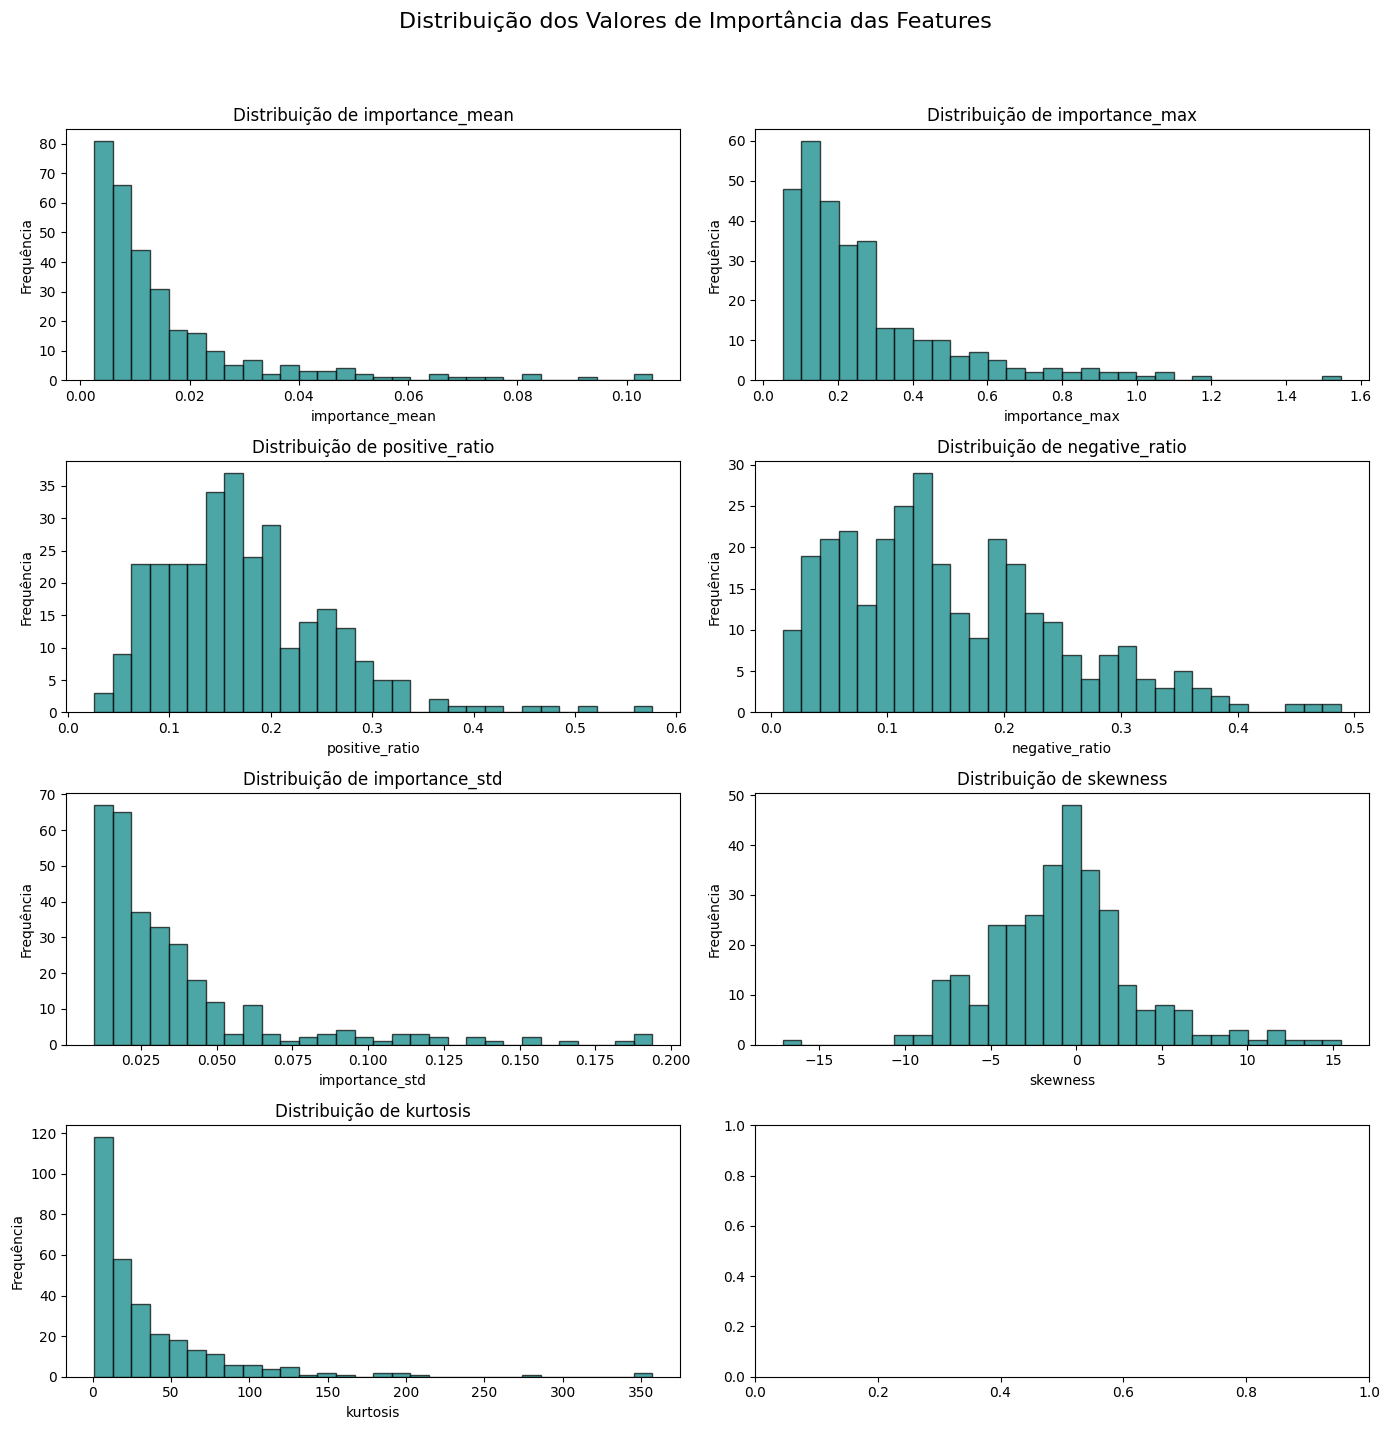

In [108]:
shap_values_df_analysis(shap_importances_df_cleaned)

## MultiClass

In [109]:
get_shap_info_per_class(shap_values,X_shap)

### Class 0

In [110]:
class0_df = pd.read_csv("../Dataset/SHAP_Values/class0_shap_values.csv")
class0_df.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.015827,0.069107,0.011763,0.168693,0.169193
std,0.043329,0.143441,0.025056,0.276563,0.277205
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.015180,0.086972,0.016304,0.335246,0.294262
max,0.381876,1.000000,0.226321,0.947541,0.986885


In [111]:
class0_discard_features = class0_df[
        (class0_df["importance_mean"] <= 0.00) &
        (class0_df["importance_max"] <= 0.00) 
    ]["feature"].tolist()
print(len(class0_discard_features))

203


### Class 1

In [112]:
class1_df = pd.read_csv("../Dataset/SHAP_Values/class1_shap_values.csv")
class1_df.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.015479,0.072676,0.012873,0.187513,0.176389
std,0.035340,0.141997,0.027206,0.289495,0.278333
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.014638,0.097593,0.017030,0.348361,0.302459
max,0.321124,1.000000,0.234767,0.954098,0.960656


In [113]:
class1_discard_features = class1_df[
        (class1_df["importance_mean"] <= 0.0)
    ]["feature"].tolist()
print(len(class1_discard_features))

194


### Class 2

In [114]:
class2_df = pd.read_csv("../Dataset/SHAP_Values/class2_shap_values.csv")
class2_df.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.003568,0.016884,0.002805,0.032393,0.049489
std,0.020167,0.083776,0.013578,0.118453,0.173533
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.254248,1.000000,0.169131,0.770492,0.960656


In [115]:
class2_discard_features = class2_df[
        (class2_df["importance_mean"] <= 0.0)
    ]["feature"].tolist()
print(len(class2_discard_features))

282


### Class 3

In [116]:
class3_df = pd.read_csv("../Dataset/SHAP_Values/class3_shap_values.csv")
class3_df.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.018155,0.074152,0.013914,0.231893,0.183692
std,0.045380,0.149488,0.028508,0.316851,0.268577
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.014777,0.095106,0.016818,0.535246,0.357377
max,0.340538,1.000000,0.204183,0.993443,0.980328


In [117]:
class3_discard_features = class3_df[
        (class3_df["importance_mean"] <= 0.0)
    ]["feature"].tolist()
print(len(class3_discard_features))

180


### Class 4

In [118]:
class4_df = pd.read_csv("../Dataset/SHAP_Values/class4_shap_values.csv")
class4_df.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio
count,308.000000,308.000000,308.000000,308.000000,308.000000
mean,0.017420,0.080947,0.015069,0.246583,0.194188
std,0.039063,0.139155,0.025611,0.318990,0.268950
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.021687,0.120189,0.021095,0.541803,0.338525
max,0.415499,1.000000,0.167692,0.937705,0.950820


In [119]:
class4_discard_features = class4_df[
        (class4_df["importance_mean"] <= 0.0)
    ]["feature"].tolist()
print(len(class4_discard_features))

170


In [120]:
# Lista das features a descartar para cada classe
class_discard_features = [class0_discard_features, class1_discard_features, class2_discard_features, class3_discard_features, class4_discard_features]

# Contar quantas classes descartam cada feature
feature_counts = {}
for discard_list in class_discard_features:
    for feature in discard_list:
        if feature not in feature_counts:
            feature_counts[feature] = 0
        feature_counts[feature] += 1

# Selecionar as features que são descartadas em 3 ou mais classes
combined_classes = [feature for feature, count in feature_counts.items() if count > 3]

# Verificar quantas features serão descartadas
print(len(combined_classes))

142


In [121]:
shap_train_df = shap_train_df.drop(columns=combined_classes)
shap_control_df = shap_control_df.drop(columns=combined_classes)
shap_test_df = shap_test_df.drop(columns=combined_classes)
shap_train_df.to_csv("../Dataset/train_df_without_shap_low_values.csv",index=False)
shap_importances_df_cleaned = clean_shap_df(shap_importances_df_cleaned,combined_classes)

In [122]:
shap_values = new_shap_values(shap_values,combined_classes)
X_shap = shap_train_df.drop("Transition_code",axis=1)

In [123]:
shap_importances_df_cleaned.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness,kurtosis
count,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000,166.000000
mean,0.018342,0.309758,0.039439,0.220822,0.216682,-0.063652,38.613066
std,0.018920,0.253510,0.036531,0.080702,0.082875,4.343613,53.512653
min,0.003195,0.052302,0.009555,0.054426,0.035410,-8.225870,0.949640
25%,0.007303,0.139507,0.017690,0.169836,0.159016,-2.606857,6.628958
50%,0.011578,0.226270,0.027612,0.206557,0.205902,-0.449715,17.832726
75%,0.020793,0.385400,0.042636,0.262951,0.264426,1.607515,48.417026
max,0.104727,1.547248,0.193842,0.576393,0.488525,15.480292,357.162458


### SHAP Plots

In [ ]:
show_shap_importance_summary_plot(shap_values,X_shap, 0)
show_shap_importance_heatmap(shap_values,X_shap, 0)

In [ ]:
show_shap_importance_summary_plot(shap_values,X_shap, 1)
show_shap_importance_heatmap(shap_values,X_shap, 1)

In [ ]:
show_shap_importance_summary_plot(shap_values,X_shap, 2)
show_shap_importance_heatmap(shap_values,X_shap, 2)

In [ ]:
show_shap_importance_summary_plot(shap_values,X_shap, 3)
show_shap_importance_heatmap(shap_values,X_shap, 3)

In [ ]:
show_shap_importance_summary_plot(shap_values,X_shap, 4)
show_shap_importance_heatmap(shap_values,X_shap, 4)

## Features Correlation

In [124]:
target = shap_train_df["Transition_code"]
correlations_with_target = shap_train_df.corrwith(target)
corr_matrix = shap_train_df.corr()

# Obter pares de features com correlação alta
high_corr_pairs = [
    (feature1, feature2)
    for feature1, feature2 in zip(*np.where(np.abs(corr_matrix) > 0.90))
    if feature1 != feature2
]

corr_features_to_remove = []
for feature1, feature2 in high_corr_pairs:
    if correlations_with_target[feature1] > correlations_with_target[feature2]:
        corr_features_to_remove.append(shap_train_df.columns[feature2])
    else:
        corr_features_to_remove.append(shap_train_df.columns[feature1])

# Remover duplicados
corr_features_to_remove = list(set(corr_features_to_remove))

print(len(corr_features_to_remove))

15


/var/folders/mw/3tkw6q2j7wn1mq2731n0bv_40000gn/T/ipykernel_21949/1480930964.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if correlations_with_target[feature1] > correlations_with_target[feature2]:


In [125]:
shap_train_df = shap_train_df.drop(columns=corr_features_to_remove)
shap_control_df = shap_control_df.drop(columns=corr_features_to_remove)
shap_test_df = shap_test_df.drop(columns=corr_features_to_remove)
shap_train_df.to_csv("../Dataset/train_df_without_shap_low_values.csv",index=False)
shap_importances_df_cleaned = clean_shap_df(shap_importances_df_cleaned,corr_features_to_remove)

In [126]:
shap_values = new_shap_values(shap_values,corr_features_to_remove)
X_shap = shap_train_df.drop("Transition_code",axis=1)

In [127]:
shap_importances_df_cleaned.describe()

,importance_mean,importance_max,importance_std,positive_ratio,negative_ratio,skewness,kurtosis
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,0.018724,0.314505,0.039916,0.224058,0.217496,-0.180763,38.594080
std,0.019433,0.260361,0.037526,0.081800,0.085203,4.303545,53.853085
min,0.003195,0.052302,0.009555,0.054426,0.035410,-8.225870,0.949640
25%,0.007099,0.139807,0.017651,0.176721,0.158689,-2.676206,6.629358
50%,0.011403,0.225184,0.026922,0.207213,0.206557,-0.533084,17.320424
75%,0.021765,0.378293,0.043254,0.264262,0.266557,1.436111,48.330570
max,0.104727,1.547248,0.193842,0.576393,0.488525,15.480292,357.162458


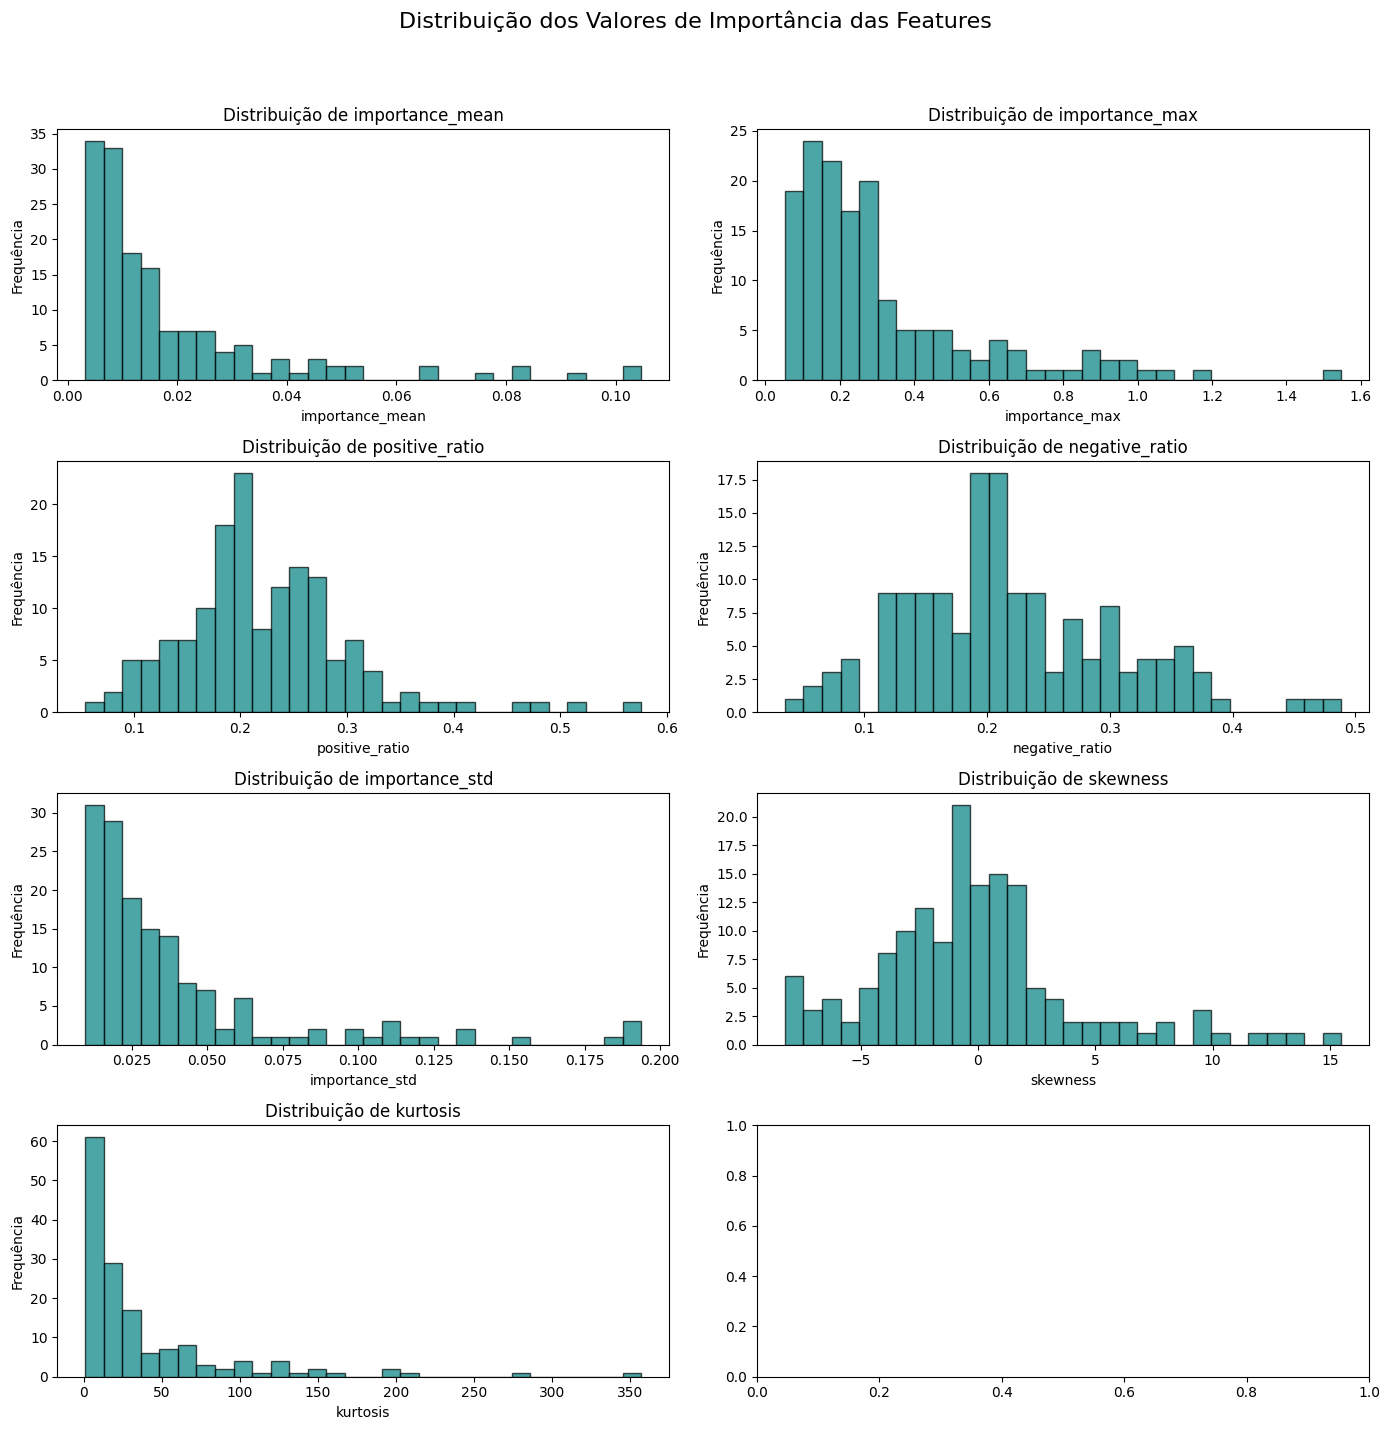

In [128]:
shap_values_df_analysis(shap_importances_df_cleaned)

# Models Tester

In [129]:
results = {}
x_train, x_test, y_train, y_test = define_X_y(shap_train_df,shap_test_df,random_state=12)
main_exploration(x_train)
main_exploration(x_test)


(305, 151)
(100, 151)


## Basic Models

F1 Macro Score em RandomForest: 0.3575499032047158 ± 0.044
F1 Macro Score em XGBoost: 0.3657737397713849 ± 0.056
F1 Macro Score em LightGBM: 0.42922664859097126 ± 0.086
F1 Macro Score em SVM: 0.35906888179289315 ± 0.056


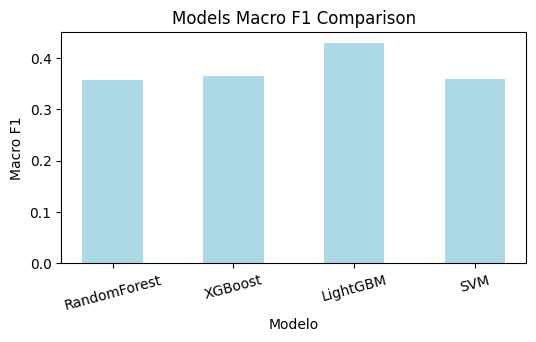

In [130]:
rf_model, xgb_model, gradient_model, cat_model, log_model, light_model,svm_model = apply_basic_models(x_train,y_train,x_test,y_test,n_repeats=3)

F1 Macro Score em RandomForest: 0.3575499032047158
F1 Macro Score em XGBoost: 0.3657737397713849
F1 Macro Score em LightGBM: 0.42922664859097126
F1 Macro Score em SVM: 0.35906888179289315
F1 Macro Score em StackingBasicSVM: 0.3735724776680761 ± 0.05


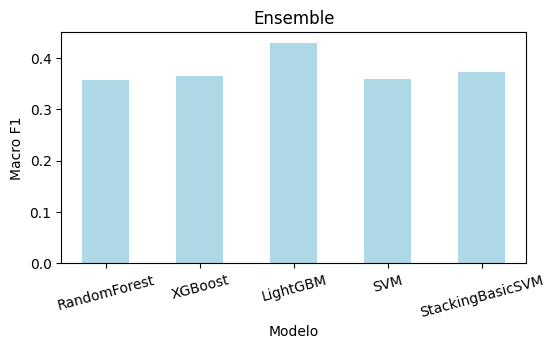

In [131]:
#stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_model),("xgb",xgb_model),("light",light_model)])
#results["StackingBasic"] = [stacking_model,None]
stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_model),("rf",rf_model),("xgb",xgb_model),("light",light_model)])
results["StackingBasicSVM"] = [stacking_model_svm,None]

#stacking_model_svm_grid = stacking_ensemble(x_train,y_train,[("svm",svm_preds_model),("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])
#results["StackingGridSVM"] = [stacking_model_svm_grid,None]

models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=4)

In [ ]:
class_accuracy(stacking_model_svm,x_test,y_test)

In [ ]:
models = {"RF": rf_model,"XGB": xgb_model,"Light":light_model,"Stacking": stacking_model_svm}
roc_auc(models,x_train, y_train, x_test, y_test)

## BayesOptimizer Tuning

In [ ]:
def bayes_visualization(params,bayes_results,best_hyperparameters):
    param_names = list(params.keys())

    cols = 3
    rows = math.ceil(len(param_names)/cols)
    
    fig, axes = plt.subplots(rows,cols,figsize=(4*cols,4*rows))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, param in enumerate(param_names):
        if param != "target":
            ax = axes[i//3, i%3]
            ax.plot(bayes_results['params'].apply(lambda x: x[param]),
                bayes_results['target'], 'bo-', lw=1, markersize=4)
            ax.set_title(f'Optimization of {param}')
            ax.set_xlabel(param)
            ax.set_ylabel('F1 Macro Score')
     
            best_value = best_hyperparameters['params'][param]
            ax.plot(best_value, best_hyperparameters['target'], 'yo', markersize=6)
            
    for i in range(len(param_names), 6):
        fig.delaxes(axes.flatten()[i])
 
    plt.show()

In [ ]:
results = {}

rf_baye_model, rf_baye_results, best_params = random_forest_baye_model(x_train,y_train)
results["RandomForestBaye"] = [rf_baye_model,None]
bayes_visualization(param_baye_rf, rf_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

xgb_baye_model, xgb_baye_results, best_params = xgboost_baye_model(x_train,y_train)
results["XGBoostBaye"] = [xgb_baye_model,None]
bayes_visualization(param_baye_xgb, xgb_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

light_baye_model, light_baye_results, best_params = light_baye_train_model(x_train,y_train)
results["LightBoostBaye"] = [light_baye_model,None]
bayes_visualization(param_baye_light, light_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

svm_baye_model, svm_baye_results, best_params = svm_baye_train_model(x_train,y_train)
results["SVMBaye"] = [svm_baye_model,None]
bayes_visualization(param_baye_svm, svm_baye_results, best_params)
models_comparison(results, "BayeSearch",x_train=x_train,y_train=y_train)

In [ ]:
rf_ensemble = RandomForestClassifier(**rf_baye_model.get_params())

In [ ]:
xgb_ensemble = XGBClassifier(**xgb_baye_model.get_params())

In [ ]:
light_ensemble = lgb.LGBMClassifier(**light_baye_model.get_params())

In [ ]:
svm_ensemble = SVC(**svm_baye_model.get_params())

In [ ]:
stacking_model = stacking_ensemble(x_train,y_train,[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
results["StackingBaye"] = [stacking_model,None]
stacking_model_svm = stacking_ensemble(x_train,y_train,[("svm",svm_ensemble),("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
results["StackingBayeSVM"] = [stacking_model_svm,None]

models_comparison(results,"Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

In [ ]:
class_accuracy(stacking_model_svm,x_test,y_test)

## GridSearch Tuning

Fitting 15 folds for each of 768 candidates, totalling 11520 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 768 is smaller than n_iter=1000. Running 768 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': False}
F1 Macro Score em RandomForestGrid: 0.37467714425505805 ± 0.053


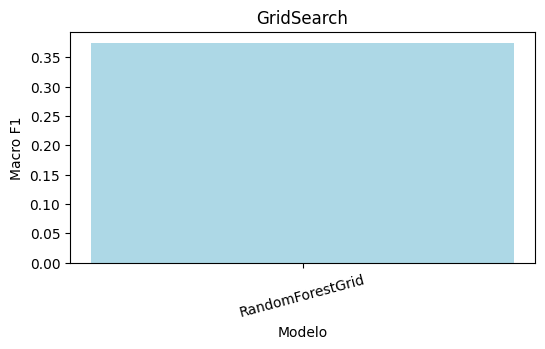

Fitting 15 folds for each of 1000 candidates, totalling 15000 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'subsample': 0.7, 'objective': 'multi:softprob', 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 1, 'colsample_bytree': 0.7, 'alpha': 0.05}
F1 Macro Score em RandomForestGrid: 0.37467714425505805
F1 Macro Score em XGBoostGrid: 0.3989843359760325 ± 0.047


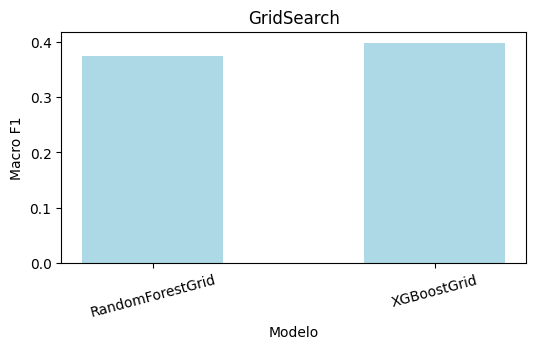

Fitting 15 folds for each of 432 candidates, totalling 6480 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 432 is smaller than n_iter=600. Running 432 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'objective': 'multiclassova', 'num_leaves': 20, 'min_data_in_leaf': 20, 'max_depth': 5, 'learning_rate': 0.1, 'bagging_fraction': 0.5}
F1 Macro Score em RandomForestGrid: 0.37467714425505805
F1 Macro Score em XGBoostGrid: 0.3989843359760325
F1 Macro Score em lightGrid: 0.44799008378365757 ± 0.089


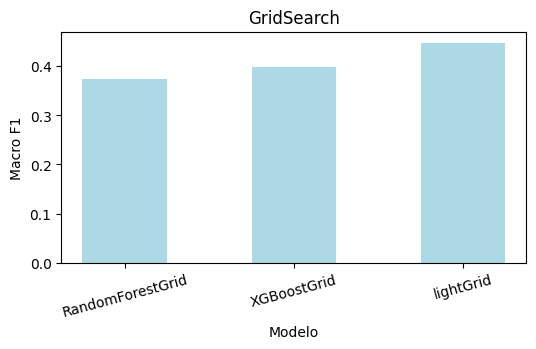

Fitting 25 folds for each of 28 candidates, totalling 700 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 28 is smaller than n_iter=600. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'kernel': 'rbf', 'gamma': 0.001, 'class_weight': 'balanced', 'C': 5}
F1 Macro Score em RandomForestGrid: 0.37467714425505805
F1 Macro Score em XGBoostGrid: 0.3989843359760325
F1 Macro Score em lightGrid: 0.44799008378365757
F1 Macro Score em SVMGrid: 0.37220478762037496 ± 0.061


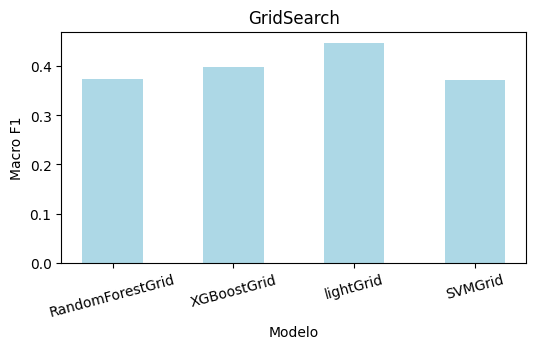

In [142]:
results = {}
rf_grid_model = random_forest_grid_model(x_train,y_train)
results["RandomForestGrid"] = [rf_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

xgb_grid_model = xgboost_grid_model(x_train,y_train)
results["XGBoostGrid"] = [xgb_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

light_grid_model = light_grid_train_model(x_train,y_train)
results["lightGrid"] = [light_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

svm_grid_model = svm_grid_train_model(x_train,y_train)
results["SVMGrid"] = [svm_grid_model,None]
models_comparison(results, "GridSearch",x_train=x_train,y_train=y_train)

F1 Macro Score em RandomForestGrid: 0.37467714425505805
F1 Macro Score em XGBoostGrid: 0.3989843359760325
F1 Macro Score em lightGrid: 0.44799008378365757
F1 Macro Score em SVMGrid: 0.37220478762037496
F1 Macro Score em StackingGrid: 0.3831544078610653 ± 0.057
F1 Macro Score em StackingGridSVM: 0.3867213180258894 ± 0.047


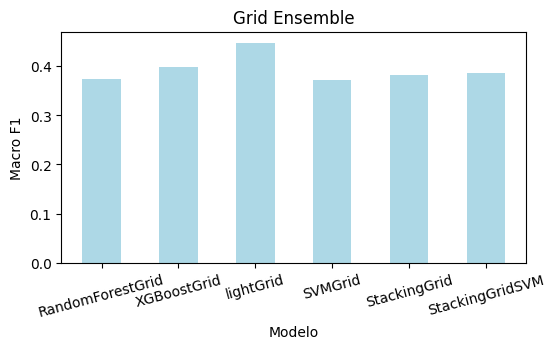

In [143]:
rf_ensemble = RandomForestClassifier(**rf_grid_model.get_params())
xgb_ensemble = XGBClassifier(**xgb_grid_model.get_params())
light_ensemble = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_ensemble = SVC(**svm_grid_model.get_params())

stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])
stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_ensemble),("rf",rf_ensemble),("xgb",xgb_ensemble),("light",light_ensemble)])

results["StackingGrid"] = [stacking_model,None]
results["StackingGridSVM"] = [stacking_model_svm,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=5)

In [ ]:
class_accuracy(stacking_model_svm,x_test,y_test)

In [ ]:
models = {"RF": rf_model,"XGB": xgb_model,"Light":light_model,"Stacking": stacking_model_svm}
roc_auc(models,x_train, y_train, x_test, y_test)

## Ensemble with Best Models

In [ ]:
rf_best_model = RandomForestClassifier(**rf_baye_model.get_params())
xgb_best_model = XGBClassifier(**xgb_grid_model.get_params())
light_best_model = lgb.LGBMClassifier(**light_grid_model.get_params())
svm_best_model = SVC(**svm_grid_model.get_params())

stacking_model = stacking_ensemble(x_train,y_train,estimators=[("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])
stacking_model_svm = stacking_ensemble(x_train,y_train,estimators=[("svm",svm_best_model),("rf",rf_best_model),("xgb",xgb_best_model),("light",light_best_model)])

results["StackingGrid"] = [stacking_model,None]
results["StackingGridSVM"] = [stacking_model_svm,None]

models_comparison(results,"Grid Ensemble",x_train=x_train,y_train=y_train,n_repeats=10)

In [ ]:
class_accuracy(stacking_model,x_test,y_test)

# Get Preds

In [144]:
results = {}
x_train_final, x_test_final, y_train_final, y_test_final = define_X_y(shap_train_df,shap_test_df,random_state=20)
main_exploration(x_train_final)
main_exploration(x_test_final)

(305, 151)
(100, 151)


In [ ]:
rf_params = rf_model.get_params()
xgb_params = xgb_model.get_params()
light_params = light_model.get_params()
svm_params = svm_model.get_params()

In [ ]:
rf_baye_params = rf_baye_model.get_params()
xgb_baye_params = xgb_baye_model.get_params()
light_baye_params = light_baye_model.get_params()
svm_baye_params = svm_baye_model.get_params()

In [145]:
rf_grid_params = rf_grid_model.get_params()
xgb_grid_params = xgb_grid_model.get_params()
light_grid_params = light_grid_model.get_params()
svm_grid_params = svm_grid_model.get_params()

In [146]:
rf_preds_model = RandomForestClassifier(**rf_grid_params)
xgb_preds_model = XGBClassifier(**xgb_grid_params)
light_preds_model = lgb.LGBMClassifier(**light_grid_params)
svm_preds_model = SVC(**svm_grid_params)

In [147]:
stacking_model = stacking_ensemble(x_train_final,y_train_final,estimators=[("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])
stacking_model_svm = stacking_ensemble(x_train_final,y_train_final,estimators=[("svm",svm_preds_model),("rf",rf_preds_model),("xgb",xgb_preds_model),("light",light_preds_model)])


## Final Test

In [148]:
def final_test_cv(model, x_train, y_train, n_repeats=5, n_splits=5,random_state=27):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    
    score_mean = cross_val_score(model, x_train, y_train, cv=cv, scoring='f1_macro').mean()
    
    print(f"F1 Score mean Stacking: {score_mean}")


In [150]:
final_test_cv(stacking_model_svm,x_train_final,y_train_final,n_repeats=5,n_splits=5,random_state=12)
final_test_cv(stacking_model_svm,x_train_final,y_train_final,n_repeats=5,n_splits=5,random_state=32)
final_test_cv(stacking_model_svm,x_train_final,y_train_final,n_repeats=5,n_splits=5,random_state=27)
final_test_cv(stacking_model_svm,x_train_final,y_train_final,n_repeats=5,n_splits=5,random_state=31)

F1 Score mean Stacking: 0.37516588326415085


KeyboardInterrupt: 

## Preds to CSV

In [151]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)
    else:
        print("Invalid input!")


In [152]:
preds_to_csv(stacking_model_svm.predict(x_test_final))

CSV updated!
 ['CN-CN' 'MCI-MCI' 'MCI-MCI' 'CN-CN' 'CN-CN' 'MCI-AD' 'AD-AD' 'CN-CN'
 'MCI-AD' 'MCI-MCI' 'MCI-MCI' 'MCI-MCI' 'MCI-AD' 'MCI-MCI' 'MCI-AD'
 'CN-CN' 'CN-CN' 'MCI-AD' 'MCI-AD' 'AD-AD' 'MCI-MCI' 'MCI-MCI' 'CN-CN'
 'MCI-MCI' 'AD-AD' 'MCI-MCI' 'AD-AD' 'AD-AD' 'CN-CN' 'CN-CN' 'CN-CN'
 'MCI-MCI' 'MCI-AD' 'AD-AD' 'MCI-MCI' 'MCI-AD' 'MCI-AD' 'CN-CN' 'CN-CN'
 'CN-CN' 'MCI-AD' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN' 'MCI-AD' 'MCI-MCI'
 'CN-CN' 'AD-AD' 'CN-CN' 'MCI-MCI' 'CN-CN' 'MCI-AD' 'AD-AD' 'CN-CN'
 'AD-AD' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'CN-CN' 'AD-AD' 'CN-CN' 'AD-AD'
 'MCI-MCI' 'CN-CN' 'CN-CN' 'CN-CN' 'MCI-AD' 'CN-CN' 'MCI-AD' 'MCI-AD'
 'CN-CN' 'MCI-AD' 'AD-AD' 'MCI-AD' 'MCI-AD' 'CN-CN' 'CN-CN' 'CN-CN'
 'CN-CN' 'MCI-MCI' 'AD-AD' 'CN-CN' 'MCI-AD' 'CN-CN' 'AD-AD' 'MCI-MCI'
 'MCI-MCI' 'CN-CN' 'AD-AD' 'CN-CN' 'MCI-MCI' 'CN-CN' 'MCI-AD' 'MCI-MCI'
 'AD-AD' 'MCI-AD' 'CN-CN' 'AD-AD']


In [ ]:
save_stuff(stacking_model,"Models/New_Models/new_era_stacking.pkl")
save_stuff(stacking_model_svm,"Models/New_Models/new_era_stackingsvm.pkl")

In [ ]:
stacking_model